<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import PolynomialFeatures

In [22]:
data = pd.read_csv('data_clean_v1.csv')

In [23]:
data.shape

(14375, 19)

In [24]:
data.head()

,Unnamed: 0,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,salary_group,role_group
0,1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,2,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,25000-29999,India,Medium,Small,27500.0,between 10k and 30k,Other
1,2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,4,Under 1 year,Manufacturing/Fabrication,"1000-9,999 employees",1-2,60000-69999,Other,Large,Small,65000.0,between 50k and 80k,Data Analyst
2,3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,3,No experience,Academics/Education,"1000-9,999 employees",0,0-999,Other,Large,No team,500.0,less than 10k,Data Engineer
3,4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,5-10 years,Academics/Education,"1000-9,999 employees",0,30000-39999,Other,Large,No team,35000.0,between 30k and 50k,Data Scientist
4,5,45-49,Man,India,Doctoral degree,Other,< 1 years,3,10-20 years,Academics/Education,50-249 employees,5-9,30000-39999,India,Medium,Small,35000.0,between 30k and 50k,Other


In [25]:
data = data.drop(['Unnamed: 0'], axis=1)

In [26]:
#data_eu = data[data['country_group'] == 'Europe']

In [27]:
def dist_boxplot_num(data, skip_columns=[]):
    for col in data.select_dtypes(np.number):
        if col not in skip_columns:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            sns.distplot(data[col], ax=axes[0])
            sns.boxplot(data[col], ax=axes[1])
            plt.show()

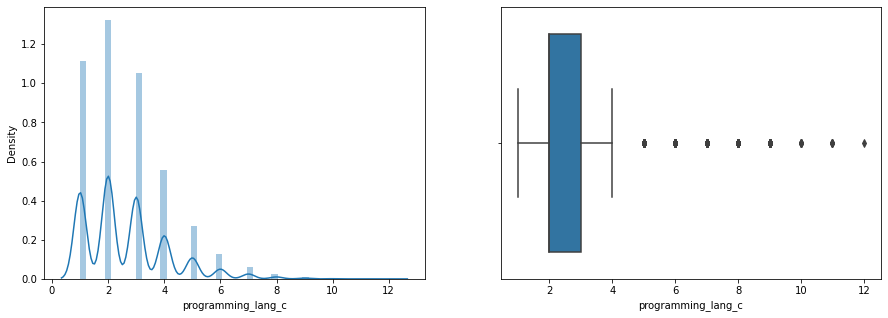

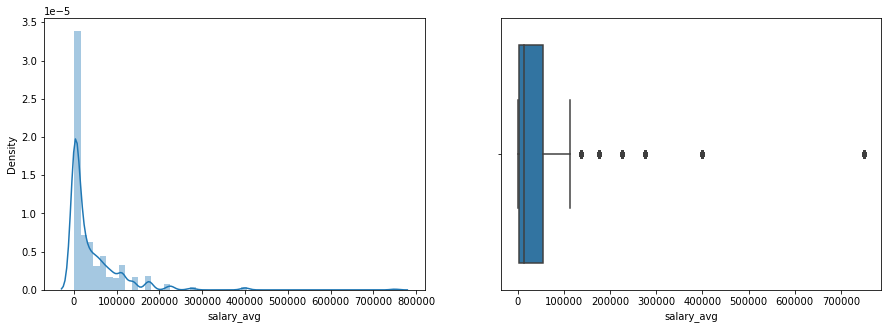

In [28]:
dist_boxplot_num(data)

In [29]:
def boxcox_transform(data, skip_columns=[]):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if column not in skip_columns:
# since i know any columns should take negative numbers, to avoid -inf in df
            data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].mean())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data, _ci

In [30]:
data, _ci = boxcox_transform(data, skip_columns = ['programming_lang_c'])
data

,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,salary_group,role_group
0,50-54,Man,India,Bachelor’s degree,Other,5-10 years,2,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,25000-29999,India,Medium,Small,16.054887,between 10k and 30k,Other
1,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,4,Under 1 year,Manufacturing/Fabrication,"1000-9,999 employees",1-2,60000-69999,Other,Large,Small,18.128058,between 50k and 80k,Data Analyst
2,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,3,No experience,Academics/Education,"1000-9,999 employees",0,0-999,Other,Large,No team,8.120522,less than 10k,Data Engineer
3,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,5-10 years,Academics/Education,"1000-9,999 employees",0,30000-39999,Other,Large,No team,16.621337,between 30k and 50k,Data Scientist
4,45-49,Man,India,Doctoral degree,Other,< 1 years,3,10-20 years,Academics/Education,50-249 employees,5-9,30000-39999,India,Medium,Small,16.621337,between 30k and 50k,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14370,18-21,Man,India,Bachelor’s degree,Software Engineer,1-3 years,4,Under 1 year,Academics/Education,0-49 employees,1-2,0-999,India,Small,Small,8.120522,less than 10k,Data Engineer
14371,60-69,Man,USA,Bachelor’s degree,Program/Project Manager,20+ years,2,Under 1 year,Academics/Education,"10,000 or more employees",5-9,300000-499999,USA,Large,Small,23.022724,more than 125k,Data Analyst
14372,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,2,1-2 years,Manufacturing/Fabrication,"10,000 or more employees",20+,3000-3999,India,Large,Large,11.646746,less than 10k,Data Analyst
14373,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,3,3-4 years,Computers/Technology,"10,000 or more employees",20+,80000-89999,Other,Large,Large,18.805304,between 80k and 125k,Data Engineer


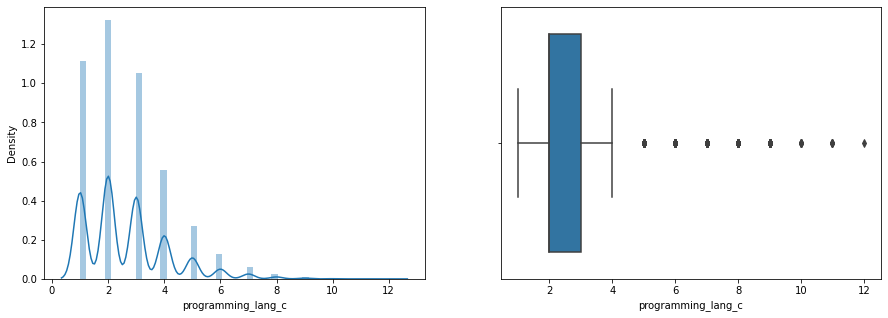

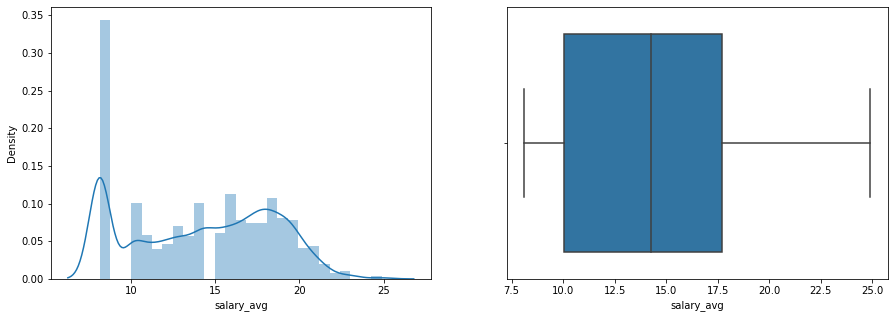

In [31]:
dist_boxplot_num(data)

In [32]:
def remove_outliers(data, threshold=1.5, in_columns=data.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(data[column],75)
            lower = np.percentile(data[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            data = data[(data[column]>lower_limit) & (data[column]<upper_limit)]
    return data

In [33]:
data = remove_outliers(data, threshold=1.5)

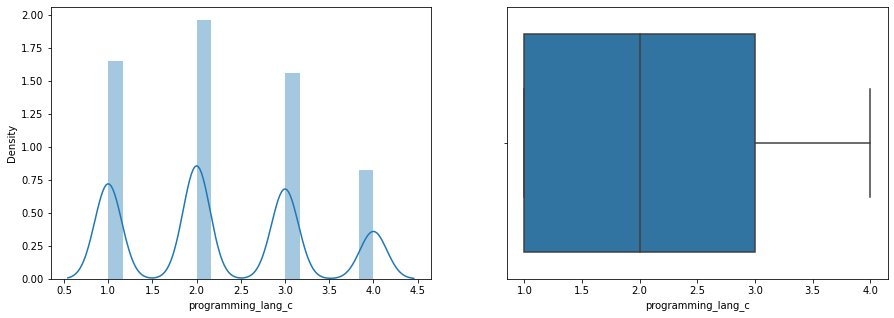

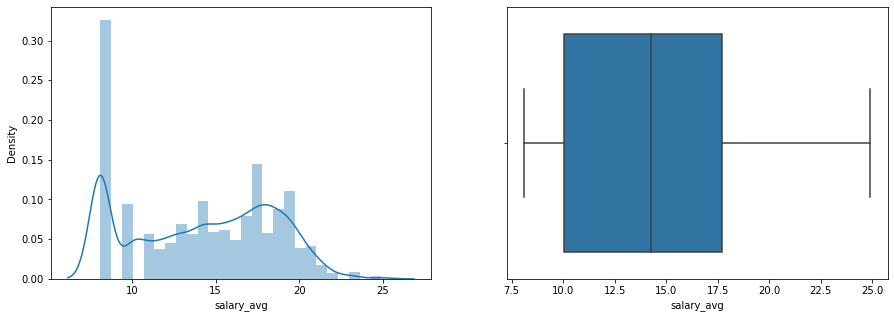

In [34]:
dist_boxplot_num(data)

In [158]:
data.shape

(12799, 18)

In [35]:
data = data.drop(['country_group','company_size', 'salary', 'salary_avg', 'team_size', 'role'], axis=1)

In [140]:
data_eu = data_eu[(data_eu.education != 'I prefer not to answer')]

In [112]:
corr_df_model = data.select_dtypes([np.number])
correlations_matrix = corr_df_model.corr()  # method='spearman'
correlations_matrix

,programming_lang_c
programming_lang_c,1.0


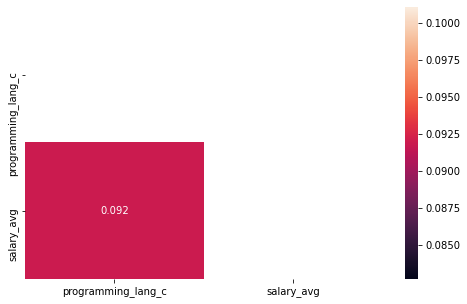

In [23]:
mask = np.zeros_like(correlations_matrix)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [113]:
data_cat = data.select_dtypes(np.object)
data_num = data.select_dtypes(np.number)

In [114]:
corr_mat = data_cat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')

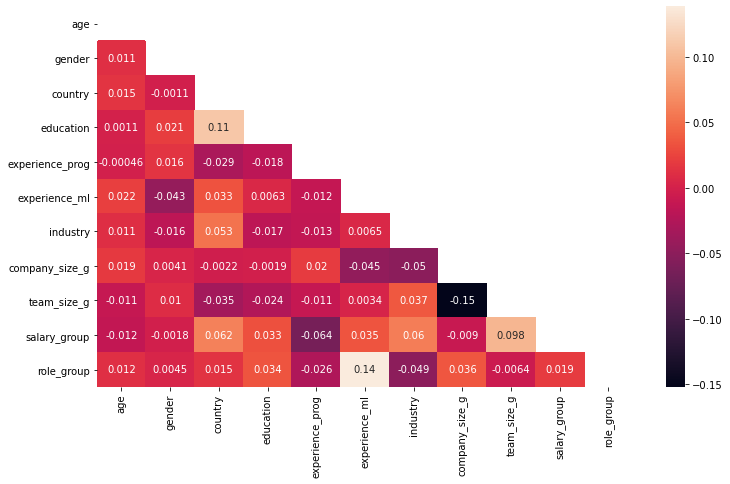

In [115]:
mask = np.zeros_like(corr_mat)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap((corr_mat), mask=mask, annot=True)
plt.show()

In [27]:
#data_cat = pd.get_dummies(data_cat)

In [28]:
#df_model_test = pd.concat([data_cat,data_num], axis=1)

In [30]:
#df_model_test.shape

(2568, 86)

In [35]:
#df_model_test.head()

,age_18-21,age_22-24,age_25-29,age_30-34,age_35-39,age_40-44,age_45-49,age_50-54,age_55-59,age_60-69,...,team_size_g_Large,team_size_g_Medium,team_size_g_No team,team_size_g_Small,role_group_Data Analyst,role_group_Data Engineer,role_group_Data Scientist,role_group_Other,programming_lang_c,salary_avg
10,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,4,59.037439
11,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,2,34.263258
17,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,2,76.612364
24,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,2,82.921494
38,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2,19.355640


In [36]:
X = data.drop('salary_group', axis=1)
y = data['salary_group']

In [37]:
X = pd.get_dummies(X)
X.head()

,programming_lang_c,age_18-21,age_22-24,age_25-29,age_30-34,age_35-39,age_40-44,age_45-49,age_50-54,age_55-59,...,company_size_g_Medium,company_size_g_Small,team_size_g_Large,team_size_g_Medium,team_size_g_No team,team_size_g_Small,role_group_Data Analyst,role_group_Data Engineer,role_group_Data Scientist,role_group_Other
0,2,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,3,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
# Building the model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

# For cross validation
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=2, random_state=0)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.45390625
0.43900780104472137


In [44]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf=1,min_samples_split=2, max_depth=13, n_estimators=400)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.518359375


In [45]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [46]:
from sklearn.metrics import mean_squared_error
t= mean_squared_error(y_test, y_pred, squared=False)

ValueError: could not convert string to float: 'less than 10k'

In [43]:
#Linear Regression

lm = LinearRegression()
lm.fit(X_train, y_train)
lm

LinearRegression()

In [44]:
print(lm.intercept_)
print(lm.coef_)

411734828626227.2
[-3.34477633e+14 -3.34477633e+14 -3.34477633e+14 -3.34477633e+14
 -3.34477633e+14 -3.34477633e+14 -3.34477633e+14 -3.34477633e+14
 -3.34477633e+14 -3.34477633e+14 -3.34477633e+14  3.15590255e+12
  3.15590255e+12  3.15590255e+12  1.06368723e+13  1.06368723e+13
  1.06368723e+13  1.06368723e+13  1.06368723e+13  1.06368723e+13
  1.06368723e+13  1.06368723e+13  1.06368723e+13  1.06368723e+13
  1.06368723e+13  1.06368723e+13  1.06368723e+13  1.06368723e+13
  1.06368723e+13  1.06368723e+13  1.06368723e+13  1.06368723e+13
  1.06368723e+13  1.06368723e+13  7.94220325e+13  7.94220325e+13
  7.94220325e+13  7.94220325e+13  7.94220325e+13  7.94220325e+13
 -2.71343342e+13 -2.71343342e+13 -2.71343342e+13 -2.71343342e+13
 -2.71343342e+13 -2.71343342e+13 -1.25198119e+13 -1.25198119e+13
 -1.25198119e+13 -1.25198119e+13 -1.25198119e+13 -1.25198119e+13
 -1.25198119e+13 -1.25198119e+13 -1.25198119e+13  4.07776765e+12
  4.07776765e+12  4.07776765e+12  4.07776765e+12  4.07776765e+12
  4.077

In [45]:
# Store linear regression predictions in variable
yhat = lm.predict(X_train)

# View first 5 predictions
print("The output of the first five predicted values are:", yhat[0:5])

The output of the first five predicted values are: [ 96.5    119.0625  65.0625  89.5625  81.75  ]


In [49]:
# Print MSE of training data
print("The mean squared error of our prediciton model is:", mean_squared_error(y_train, yhat))

The mean squared error of our prediciton model is: 600.4329466064046


In [50]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lm, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (train data): 0.40022209170671114 0.013621014082618647


In [56]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, title):
    width = 10
    height=6
    plt.figure(figsize=(width, height))
    
    ax1=sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2=sns.distplot(BlueFunction, hist=False, color="b", label=BlueName)
    
    plt.title(title)
    #plt.xlabel("Proportion of Jobs")
    #plt.ylabel("Salary (in thousand dollars)")
    plt.show()
    plt.close()

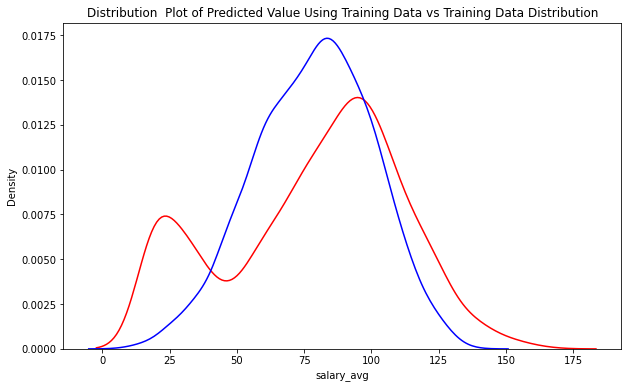

In [57]:
# View distribution of actual salaries compared to predicted salaries
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [58]:
# Store linear regression predictions in variable
yhat_test = lm.predict(X_test)

# View first 5 predictions
yhat_test[0:5]

array([92.6875, 84.8125, 81.4375, 98.9375, 81.0625])

In [59]:
# Print MSE of training data
print("The mean squared error of our test set predicitons is:", mean_squared_error(y_test, yhat_test))

The mean squared error of our test set predicitons is: 593.9715188118278


In [60]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lm, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (test data): 0.32558442439120494 0.07528122622202599


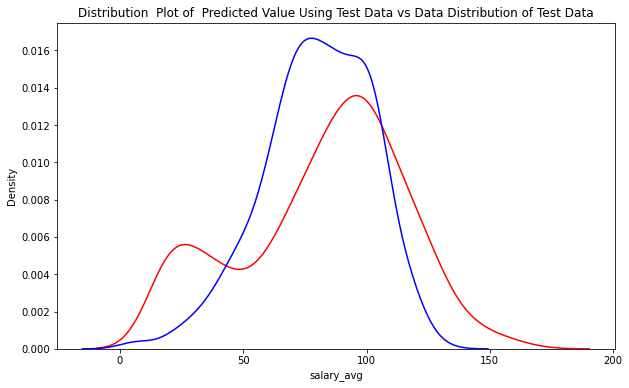

In [62]:
# View distribution of actual salaries compared to predicted salaries
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

In [63]:
rf = RandomForestRegressor(n_estimators=1000, random_state=1)

In [64]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [65]:
predictions = rf.predict(X_test)
predictions[0:5]

array([96.28451441, 79.55955425, 95.30323654, 96.03963037, 75.5067211 ])

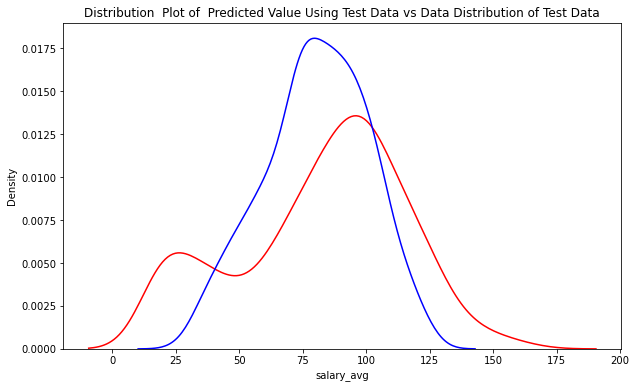

In [78]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,predictions,"Actual Values (Test)","Predicted Values (Test)",Title)

In [76]:
print("R-squared of training data:", rf.score(X_train, y_train))
print("R-squared of test data:", rf.score(X_test, y_test))
print("MSE of test data:", mean_squared_error(y_test, predictions))

R-squared of training data: 0.9145286353724552
R-squared of test data: 0.3748410316802373
MSE of test data: 688.4331580649309


In [84]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 20.12 degrees.


In [85]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 59.45 %.


In [68]:
pr = PolynomialFeatures(2)
X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)
pr

PolynomialFeatures()

In [69]:
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression()

In [70]:
yhat_prTrain = poly.predict(X_train_pr)
yhat_prTrain[0:5]

array([121.27676392, 139.90435791,  82.91912842,  85.67993164,
        92.83581543])

In [71]:
print("Predicted Values:", yhat_prTrain[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [121.27676392 139.90435791  82.91912842  85.67993164  92.83581543]
True Values: [106.33107571  96.1207576   82.92149444 106.33107571  82.92149444]


In [72]:
yhat_prTest = poly.predict(X_test_pr)
yhat_prTest[0:5]

array([ 1.74583481e+02, -7.67147827e+01, -2.33859200e+09, -1.01146103e+02,
        8.62048950e+01])

In [73]:
print("Predicted Values:", yhat_prTest[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [ 1.74583481e+02 -7.67147827e+01 -2.33859200e+09 -1.01146103e+02
  8.62048950e+01]
True Values: [106.33107571  96.1207576   82.92149444 106.33107571  82.92149444]


In [74]:
print("R-squared of training data:", poly.score(X_train_pr, y_train))
print("R-squared of test data:", poly.score(X_test_pr, y_test))

R-squared of training data: 0.9759663685284485
R-squared of test data: -3.682625893875577e+16


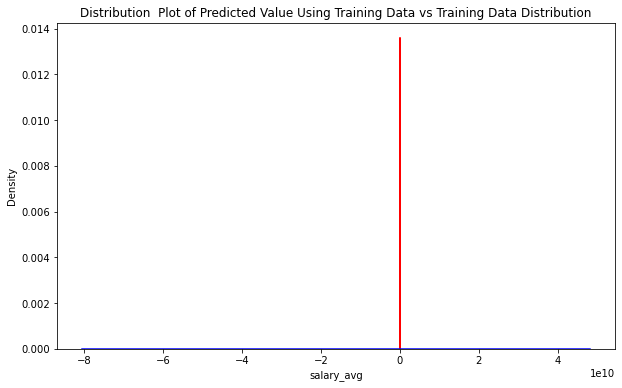

In [79]:
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, yhat_prTest, "Actual Values (Train)", "Predicted Values (Train)", Title)